# Processamento de Linguagem Natural
Professor: Yuri Malheiros

## Sequence-to-Sequence (Seq2Seq)

Neste notebook temos a implementação de uma rede Sequence-to-Sequence (Seq2Seq) utilizando o Pytorch. Utilizaremos um dataset com pares de frases em inglês e alemão. Assim, treinaremos uma rede Seq2Seq para efetuar tradução do inglês para o alemão.

Primeiramente, vamos fazer o download de dois pipelines do SpaCy, um para inglês e outro para alemão. Com isso, nós conseguiremos utilizar o tokenizador de cada idioma no nosso dataset. Na célula abaixo, `en_core_web_sm` é o pipeline para inglês e `de_core_news_sm` é o pipeline para alemão.

In [1]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 35.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 86.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Preparando os dados

Por questões de reprodutibilidade, vamos definir as seeds.

In [2]:
import random
import torch

random.seed(42)
torch.manual_seed(42)

Os dados utilizados são providos pelo Tatoeba Project e podem ser baixados aqui: https://www.manythings.org/anki/deu-eng.zip.

Faça download do arquivo, descompacte-o e copie o arquivo `deu.txt` para o seu Google Drive. No código a seguir, para ler o arquivo, eu o coloquei na pasta `datasets` no meu Google Drive.

Mas antes, vamos montar o Google Drive.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Com o Google Drive montado, vamos abrir o arquivo e ler todas as suas linhas. Em seguida, a lista com as linhas lidas é embaralhada para evitar qualquer viés que a ordem dos pares de frases possa trazer.

In [5]:
f = open('/content/drive/MyDrive/datasets/deu.txt')

lines = f.readlines()
random.shuffle(lines)

f.close()

No arquivo, cada linha é composta por três partes. A frase em inglês, a frase em alemão e a atribuição de autoria. Cada parte é dividida por uma tabulação `\t`.

In [6]:
lines[0]

'Tom is waiting in the hallway.\tTom wartet auf dem Flur.\tCC-BY 2.0 (France) Attribution: tatoeba.org #4132396 (CK) & #4134744 (Pfirsichbaeumchen)\n'

O arquivo contém 271.774 linhas.

In [7]:
len(lines)

271774

Para nosso modelo de tradução, precisamos das duas primeiras partes da linha (frase em inglês e frase em alemão). Além disso, para agilizar o treinamento do modelo, vamos utilizar apenas 50.000 linhas para treino.

In [8]:
PAIRS_LEN = 50000

pairs = {'en': [], 'de': []}

for line in lines[:PAIRS_LEN]:
  splits = line.split('\t')
  pairs['en'].append(splits[0])
  pairs['de'].append(splits[1])

In [9]:
len(pairs['en'])

50000

Veja um exemplo de um par inglês-alemão.


In [10]:
pairs['en'][0], pairs['de'][0]

('Tom is waiting in the hallway.', 'Tom wartet auf dem Flur.')

Também vamos separar 10.000 pares para teste do modelo.

In [11]:
TEST_PAIRS_LEN = 10000

test_pairs = {'en': [], 'de': []}

for line in lines[PAIRS_LEN:PAIRS_LEN+TEST_PAIRS_LEN]:
  splits = line.split('\t')
  test_pairs['en'].append(splits[0])
  test_pairs['de'].append(splits[1])

In [12]:
len(test_pairs['en'])

10000

Veja um exemplo de um par inglês-alemão do conjunto de teste.

In [13]:
test_pairs['en'][0], test_pairs['de'][0]

("I'm a translator.", 'Ich bin Übersetzerin.')

O próximo passo é dividir o texto do conjunto de treino e do conjunto de teste em tokens. Para isso, nós utilizaremos o tokenizador das pipelines carregadas do SpaCy.

In [14]:
from torchtext.data.utils import get_tokenizer

tokenizer_de = get_tokenizer('spacy', language='de_core_news_sm')
tokenizer_en = get_tokenizer('spacy', language='en_core_web_sm')

In [15]:
tokenizer_en(pairs['en'][10123])

['Tom', 'loves', 'me', 'and', 'I', 'love', 'him', ',', 'too', '.']

In [16]:
tokenizer_en(test_pairs['en'][123])

['Tom', 'and', 'only', 'Tom', 'knows', 'the', 'whole', 'truth', '.']

A função `tokenizer_all` recebe os pares carregados anteriormente e gera um dicionário com os pares tokenizados para cada idioma.

In [17]:
def tokenizer_all(pairs):
  tokens = {'en': [], 'de': []}

  for pair in pairs['en']:
    tokens['en'].append(tokenizer_en(pair.lower()))

  for pair in pairs['de']:
    tokens['de'].append(tokenizer_en(pair.lower()))

  return tokens

Vamos tokenizar os pares do conjunto de treino e do conjunto de teste.

In [18]:
tokens = tokenizer_all(pairs)

In [19]:
test_tokens = tokenizer_all(test_pairs)

In [20]:
tokens['en'][10123]

['tom', 'loves', 'me', 'and', 'i', 'love', 'him', ',', 'too', '.']

In [21]:
test_tokens['en'][123]

['tom', 'and', 'only', 'tom', 'knows', 'the', 'whole', 'truth', '.']

Após gerar os tokens, precisamos criar o vocabulário. Sabemos que em uma rede neural, os tokens são representados por números, então é necessário fazer esse mapeamento. Utilizando a função abaixo, criamos um vocabulário e teremos o mapeamento token-id. Para simplificar, consideramos apenas os tokens que aparecem pelo menos 2 vezes no dataset. Por fim, acrescentamos dois tokens especiais `<sos>` e `<eos>` que representará o início de uma frase e o fim de uma frase, respectivamente. Esses tokens são fundamentais para o funcionamento do tradutor usando uma rede Seq2Seq, eles vão indicar quando uma tradução começa e também quando ela termina.

Note que são criados dois vocabulários separados, um para inglês e outro para alemão.

In [22]:
from torchtext.vocab import build_vocab_from_iterator

vocab_en = build_vocab_from_iterator(tokens['en'], specials=['<sos>', '<eos>'], min_freq=2)
vocab_de = build_vocab_from_iterator(tokens['de'], specials=['<sos>', '<eos>'], min_freq=2)

Para consultar o id tem um token, basta consultar o seu valor como em um dicionário.

In [23]:
vocab_en['house']

145

A mesma palavra em alemão não precisa ter o mesmo id.

In [24]:
vocab_de['haus']

169

Os tokens especiais `<sos>` e `<eos>` possuem os ids 0 e 1 respectivamente.

In [25]:
vocab_en['<sos>'], vocab_en['<eos>']

(0, 1)

In [26]:
vocab_de['<sos>'], vocab_de['<eos>']

(0, 1)

Usamos a função `len` para saber a quantidade de tokens no vocabulário.

In [27]:
len(vocab_en), len(vocab_de)

(5977, 8555)

### Criando o Dataset e o Dataloader

Como estamos utilizando o Pytorch, vamos criar um Dataset, que é uma classe que define como o dataset é armazenado e acessado.

In [28]:
from torch.utils.data import Dataset

Para isso, criamos uma classe que herda de Dataset. Esta classe precisa ter três métodos: `__init__`, `__len__` e `__getitem__`.

`__init__` é o construtor da classe. Nele recebemos os dados e criamos alguns atributos de classe. `self.all_tokens` é o dicionário com todos os tokens (inglês e alemão) que criamos anteriormente. Em `self.data_en` e `self.data_de` nós transformamos as listas de tokens em listas de ids de tokens. Na rede neural, todos os dados são numéricos, então não usaremos os tokens diretamente (strings), mas sim os ids que correspondem aos tokens. Note que para o alemão, estamos adicionando antes dos tokens o `<sos>` e depois dos tokens o `<eos>`. Como nesse código o alemão é nosso idioma de saída, precisamos dos tokens especiais para controlar o início da tradução (`<sos>`) e o fim (`<eos>`).

`__len__` retorna a quantidade de exemplos do nosso dataset.

`__getitem__` retorna um exemplo de acordo com um índice. Ou seja, ao passar o índice 0 será retornado o primeiro exemplo, passando o índice 1 será retornado o segundo e assim sucessivamente. Um exemplo do nosso dataset é composto do par de lista de ids de tokens inglês - alemão.

In [29]:
class TranslationDataset(Dataset):
  def __init__(self, all_tokens, vocab_en, vocab_de):
    self.all_tokens = all_tokens
    self.data_en = []
    self.data_de = []

    for tokens in all_tokens['en']:
      tokens_index = [vocab_en[t] for t in tokens if t in vocab_en]
      self.data_en.append(tokens_index)

    for tokens in all_tokens['de']:
      tokens = ['<sos>'] + tokens + ['<eos>']
      tokens_index = [vocab_de[t] for t in tokens if t in vocab_de]
      self.data_de.append(tokens_index)

  def __len__(self):
    return len(self.all_tokens['en'])

  def __getitem__(self, index):
    return torch.LongTensor(self.data_en[index]), torch.LongTensor(self.data_de[index])

Instanciando um dataset para os dados de treino e outro para os dados de teste.

In [30]:
train_dataset = TranslationDataset(tokens, vocab_en, vocab_de)
test_dataset = TranslationDataset(test_tokens, vocab_en, vocab_de)

Notem que um exemplo é um par de tensores que representam uma lista de ids de tokens.

In [31]:
train_dataset[10123]

(tensor([  4, 474,  23,  35,   3, 154,  69,  20, 103,   2]),
 tensor([  0,   5, 516,  31,   3,  35,   4, 326,  98, 167,   2,   1]))

Podemos usar os vocabulários para converter de ids para palavras, assim retornamos ao formato textual.

In [32]:
[vocab_en.get_itos()[t] for t in train_dataset[10123][0]]

['tom', 'loves', 'me', 'and', 'i', 'love', 'him', ',', 'too', '.']

In [33]:
[vocab_de.get_itos()[t] for t in train_dataset[10123][0]]

['ich', 'schreiben', 'was', 'und', ',', 'macht', 'mehr', 'ein', 'bei', '.']

O mesmo serve para o dataset dos dados de teste.

In [34]:
test_dataset[123]

(tensor([  4,  35, 132,   4, 191,   7, 599, 357,   2]),
 tensor([  0,   5,   3,  35,  86,   5,   3, 442,  14, 370,   2,   1]))

In [35]:
[vocab_en.get_itos()[t] for t in test_dataset[123][0]]

['tom', 'and', 'only', 'tom', 'knows', 'the', 'whole', 'truth', '.']

In [36]:
[vocab_de.get_itos()[t] for t in test_dataset[123][0]]

['ich', 'und', 'ihre', 'ich', 'sicher', 'nicht', 'erinnern', 'leicht', '.']

Após criar o Dataset, nós passamos ele para instanciar um objeto da classe DataLoader. Este objeto permite iterar e acessar os exemplos do dataset de forma mais simples no Pytorch.

Vamos criar um DataLoader a partir do dataset de treino e outro a partir do dataset de teste.

In [37]:
from torch.utils.data import DataLoader

dataloader_train = DataLoader(train_dataset)
dataloader_test = DataLoader(test_dataset)

### Criando a Rede Neural

Para criar uma rede neural no Pytorch, criamos uma classe que herda de nn.Module. Nossa classe tem dois métodos: `__init__` e `forward`.

Em `__init__` criamos as camadas que fazem parte da rede.

Em `forward` recebemos a entrada e especificamos como ela vai passar pelas camadas até a saída da rede.

A rede Seq2Seq é composta de duas partes, um Encoder e um Decoder.

O Encoder possui a seguinte arquitetura:

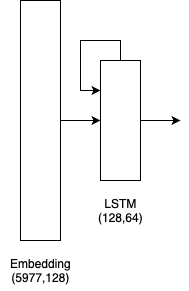

A primeira camada é uma camada de embedding. Ela recebe um id de token que é convertido internamente para um one-hot vector. Esse vetor tem tamanho 5977, ou seja, o tamanho do vocabulário em inglês, pois vamos traduzir de inglês para alemão. Essa camada retorna o embedding de 128 dimensões correspondente ao id passado.

Note que na nossa implementação, a camada de embedding recebe uma lista de ids de tokens. Cada id é convertido para o seu one-hot vector e a camada retorna uma lista de embeddings, um para cada vetor, ou seja, para cada id de token.

Em seguida, cada vetor de embedding é passado um a um para a camada LSTM. Lembre que ao passar o segundo embedding a rede LSTM também usa a saída do passo anterior quando foi passado o primeiro embedding. Essa camada, em cada passo, recebe um vetor de tamanho 128 como entrada e retorna um de tamanho 64 como saída. A camada LSTM retorna todas as saídas de todos passos (output), a última saída (hidden) e o último estado da célula (cell). A função `forward` vai retornar vai retornar o hidden e o cell.

In [38]:
from torch import nn

class Encoder(nn.Module):
  def __init__(self, input_dim, embedding_dim, hidden_dim, n_layers):
    super().__init__()

    self.hidden_dim = hidden_dim
    self.n_layers = n_layers

    self.embedding = nn.Embedding(input_dim, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers)

  def forward(self, x):
    embedding_vector = self.embedding(x)
    outputs, (hidden, cell) = self.lstm(embedding_vector)

    return hidden, cell

In [39]:
encoder = Encoder(len(vocab_en), 128, 64, 1)

Ao passar uma lista de ids de tokens em inglês para o Encoder, temos como retorno dois valores, o hidden e o cell do LSTM.

In [40]:
encoder(train_dataset[0][0])

(tensor([[ 0.1461, -0.3632,  0.0677,  0.0906, -0.1714,  0.0315, -0.1013,  0.1105,
          -0.2332, -0.1872, -0.0027, -0.1165, -0.2340,  0.2100, -0.0755, -0.0903,
          -0.1000, -0.2103,  0.0179, -0.1207,  0.0382,  0.0890, -0.3627,  0.0285,
           0.0129,  0.5908, -0.2163, -0.1351,  0.1478,  0.2832, -0.0817,  0.2473,
           0.1780,  0.1593,  0.0232, -0.2659,  0.0450,  0.3377,  0.0561,  0.0745,
          -0.1208, -0.0707, -0.2865, -0.1645,  0.3728, -0.1019, -0.0982, -0.6183,
          -0.2108, -0.2089,  0.0585, -0.0193, -0.3653,  0.1887, -0.0627,  0.0915,
           0.3717,  0.0217, -0.1198,  0.0597, -0.2428,  0.1848,  0.1379,  0.2247]],
        grad_fn=<SqueezeBackward1>),
 tensor([[ 0.3040, -1.0484,  0.1345,  0.3691, -0.2792,  0.0434, -0.2275,  0.4589,
          -0.3444, -0.3496, -0.0035, -0.2358, -0.3419,  0.3759, -0.2313, -0.2805,
          -0.2265, -0.3312,  0.0642, -0.2084,  0.0584,  0.1329, -1.0029,  0.0675,
           0.0338,  0.9334, -0.5109, -0.1589,  0.4538,  1.1

O Decoder possui a seguinte arquitetura:

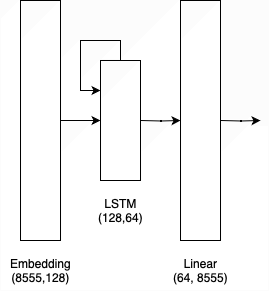

A primeira camada é uma camada de embedding como no Encoder, mas nesse caso ela recebe um one-hot vector de tamanho 8555, que é o tamanho do vocabulário em alemão, pois vamos traduzir do inglês para o alemão. Essa camada retorna o embedding de 128 dimensões correspondente ao id de token passado.

Em seguida, o vetor de embedding é passado para uma camada LSTM. No Decoder, o primeiro token passado é o `<sos>` para iniciar a tradução. Nesse caso, os valores de hidden e cell iniciais serão os valores de hidden e cell finais do Encoder, assim conectamos as duas partes numa única rede Seq2Seq.

Para finalizar, a última saída da camada LSTM é passada para uma camada totalmente conectada (Linear). Essa camada recebe um vetor de tamanho 64 e retorna um vetor de tamanho 8555, ou seja, o tamanho do vocabulário no idioma traduzido (alemão). Para saber qual o token que sai do Decoder, basta olhar a posição do maior valor do vetor de saída. Se o maior valor for, por exemplo, o índice 50, então o token com id 50 é o token retornado.

Após gerar um token de saída, ele é usado como entrada do Decoder e o processo se repete até que ele gere um token `<eos>` ou que ele gere um quantidade máxima de tokens definida.

In [41]:
from torch import nn

class Decoder(nn.Module):
  def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers):
    super().__init__()

    self.hidden_dim = hidden_dim
    self.n_layers = n_layers
    self.output_dim = output_dim

    self.embedding = nn.Embedding(output_dim, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers)
    self.linear = nn.Linear(hidden_dim, output_dim)

  def forward(self, x, hidden, cell):
    embedding_vector = self.embedding(x)
    outputs, (hidden, cell) = self.lstm(embedding_vector, (hidden, cell))
    prediction = self.linear(hidden)

    return prediction, hidden, cell

In [42]:
decoder = Decoder(len(vocab_de), 128, 64, 1)

Ao passar uma entrada para o Decoder, ele retorna o vetor que indica o token previsto e também o hidden e o cell do LSTM.

In [43]:
decoder(torch.LongTensor([0]), torch.zeros(1,64), torch.zeros(1,64))

(tensor([[-0.1225, -0.1167,  0.0330,  ...,  0.0748, -0.0383, -0.0926]],
        grad_fn=<AddmmBackward0>),
 tensor([[-0.0553, -0.0289, -0.0626, -0.2369,  0.0931, -0.2649,  0.2655, -0.0157,
          -0.1895, -0.1397, -0.0195, -0.1597, -0.1251, -0.1065,  0.1602,  0.0326,
          -0.0566,  0.1228,  0.0470, -0.0673,  0.0788, -0.1788, -0.0017,  0.1333,
           0.1611,  0.1788, -0.1205, -0.0440,  0.0716, -0.2015, -0.0080,  0.0088,
           0.0600,  0.2735, -0.0434,  0.0469,  0.0662,  0.0424,  0.0464,  0.1469,
          -0.1839, -0.0130, -0.1696, -0.1214,  0.0995, -0.0760,  0.1314, -0.0568,
          -0.1814, -0.1904, -0.1264, -0.0413,  0.0451, -0.0133, -0.0959, -0.0169,
           0.0438, -0.0351,  0.3722, -0.0840, -0.3564, -0.1152,  0.1002, -0.0774]],
        grad_fn=<SqueezeBackward1>),
 tensor([[-0.1439, -0.1299, -0.1404, -0.5240,  0.3439, -0.4127,  0.4731, -0.0651,
          -0.3292, -0.4471, -0.0218, -0.2797, -0.2041, -0.1697,  0.6835,  0.2540,
          -0.1742,  0.3457,  0.128

Juntando o Encoder e o Decoder, temos a seguinte arquitetura.

O Encoder é conectado ao Decoder através da camada LSTM. Os últimos valores de hidden e cell do Encoder são passados como os valores iniciais da camada LSTM do Decoder.

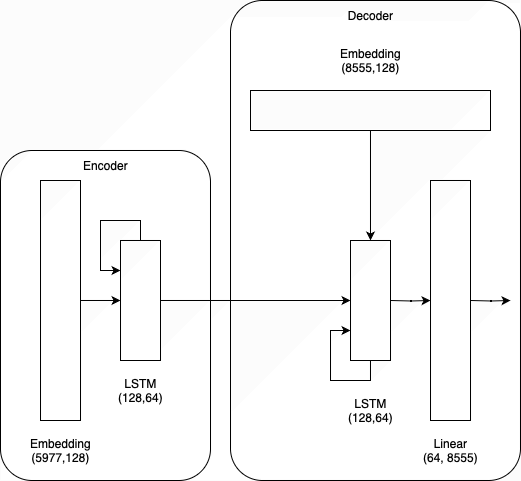

A seguir, vamos criar o modelo que junta o Encoder e o Decoder. Nessa implementação, o modelo abaixo vai ser usado apenas para o treinamento do Encoder e do Decoder. Para efetuar a tradução para novas entradas, usaremos o Encoder e o Decoder de forma separada.

O construtor do modelo Seq2Seq recebe o Encoder, o Decoder e o device onde o modelo vai rodar, preferenciamente na GPU. Como as camadas foram criadas no Encoder e no Decoder, aqui no Seq2Seq, não criaremos nenhuma camada nova.

No método `forward`, além da entrada, também passamos a saída esperada e um parâmetro que é a probabilidade de usar uma técnica chamada teacher forcing.

Como esse modelo vai ser usado apenas para o treino, não tem problema passarmos a saída esperada. Vamos usar esses dados para saber quantos tokens devemos tentar traduzir e também para o teacher forcing.

Ao treinar um modelo Seq2Seq, o Decoder gera sua saída de forma iterativa, um token por vez. A geração de um novo token depende dos tokens gerados anteriormente. Assim, se o Decoder gerar um token errado, as chances do próximo token ser errado é ainda maior. Por isso, usando o teacher forcing, nós forçamos o Decoder a receber o token certo, mesmo quando o previsto for errado. Isso facilita o treinamento e ajuda o modelo a aprender mais rápido.

O código abaixo possui comentários para explicar o seu funcionamento de forma detalhada.


In [44]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, device):
    super().__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.device = device

  # O método forward recebe a entrada (source), mas também a
  # saída esperada (target) e um parâmetro que define a probabilidade
  # de usarmos o teacher forcing.
  def forward(self, source, target, teacher_forcing_ratio=0.9):
    # A entrada e a saída são passadas para o device.
    source = source.to(self.device)
    target = target.to(self.device)

    target_len = target.shape[0]  # Quantidade de tokens na saída.
    target_vocab_size = self.decoder.output_dim  # Tamanho do vocabulário da saída.

    # Esse tensor tem a primeira dimensão com o tamanho igual o tamanho da saída.
    # Ou seja, o tensor vai guardar todas as saídas do decoder.
    # Cada saída do decoder tem shape (1, target_vocab_size), por isso,
    # definimos as outras duas dimensões do tensor outputs com esses mesmos
    # valores.
    outputs = torch.zeros(target_len, 1, target_vocab_size).to(self.device)
    outputs[0][0][0] = 1  # O token inicial é o <sos> que tem índice 0.

    # O encoder é executado.
    hidden, cell = self.encoder(source)

    # Para iniciar a execução do Decoder, nós começamos sempre com o token
    # <sos> que será sempre o primeiro token do target.
    input = target[0]
    input = input.unsqueeze(0)

    # O Decoder será executado um número de vezes de acordo com o tamanho
    # da saída. Como o primeiro token é o <sos>, começamos o for do índice 1,
    # não do 0.
    for t in range(1, target_len):

      # Note que na primeira iteração do for, o hidden e o cell passados para o
      # Decoder é o hidden e o cell do Encoder. Para as próximas iterações,
      # o hidden e cell do Decoder será o hidden e o cell da iteração anterior.
      prediction, hidden, cell = self.decoder(input, hidden, cell)

      outputs[t] = prediction  # Resultado é adicionado aos outputs.
      top1 = prediction.argmax(1)  # É escolhido o id de token com o maior valor.

      # Teste para saber se usaremos o teacher forcing.
      teacher_force = random.random() < teacher_forcing_ratio

      # Caso o teacher forcing seja usado, o token que será usado de entrada
      # na próxima iteração do Decoder será o token correto vindo dos dados da
      # saída esperada (target) que é passado na chamada do método forward.
      # Se o teacher forcing não for usado, o token de entrada na próxima
      # iteração será o token previsto nessa iteração.
      input = target[t].unsqueeze(0) if teacher_force else top1

    return outputs



Vamos instanciar o modelo Seq2Seq.

In [45]:
device = torch.device('cuda')
seq2seq = Seq2Seq(encoder, decoder, device).to(device)

### Treinamento

Para o treinamento, vamos usar o otimizador Adam e a função de erro entropia cruzada.

In [46]:
from torch import optim

optimizer = optim.Adam(seq2seq.parameters())
loss_fn = nn.CrossEntropyLoss()

O próximo passo é criar uma função que vai executar o treinamento.

O código abaixo possui comentários para explicar o seu funcionamento de forma detalhada.

In [47]:
from tqdm.notebook import tqdm

def train():
  seq2seq.train()  # Coloca o modelo no modo de treinamento.

  epoch_loss = 0  # inicia o loss de cada época.

  # A cada iteração do for temos um par de ids de tokens inglês-alemão.
  for source, target in tqdm(dataloader_train):
    # Reseta os gradientes.
    optimizer.zero_grad()

    # Os dados são passados para a GPU.
    source = source.to(device)
    target = target.to(device)

    # Ajustes nas dimensões.
    source = source.squeeze(0)
    target = target.squeeze(0)

    # Entrada e saída esperada são passadas para o modelo.
    output = seq2seq(source, target)

    # O primeiro token sempre será <sos>, então vamos removê-lo para o
    # cálculo da função de erro.
    output = output[1:]
    target = target[1:]

    # Ajuste nas dimensões.
    output = output.permute(1, 0, 2)
    output = output.squeeze(0)

    # Cálculo da função de erro.
    loss = loss_fn(output, target)

    # Backpropagation e atualização dos pesos.
    loss.backward()
    optimizer.step()

    # O erro é acumulado.
    epoch_loss += loss.item()

  # Retorna a média do erro.
  return epoch_loss/len(dataloader_train)

Criaremos a função `test` para testar o modelo nos dados de testes. Essa função é similar a função `train`, mas sem a atualização do modelo.

O código abaixo possui comentários para explicar o seu funcionamento de forma detalhada.

In [48]:
def test():
  seq2seq.eval()  # Coloca o modelo no modo de teste.
  epoch_loss = 0

  # Não vamos atualizar o modelo, por isso, podemos desabilitar o cálculo dos
  # gradientes.
  with torch.no_grad():

    # A cada iteração do for temos um par de ids de tokens inglês-alemão.
    for source, target in tqdm(dataloader_test):

      # Os dados são passados para a GPU.
      source = source.to(device)
      target = target.to(device)

      # Ajustes nas dimensões.
      source = source.squeeze(0)
      target = target.squeeze(0)

      # Entrada e saída esperada é passada para o modelo.
      output = seq2seq(source, target)

      # O primeiro token sempre será <sos>, então vamos removê-lo para o
      # cálculo da função de erro.
      output = output[1:]
      target = target[1:]

      # Ajuste nas dimensões.
      output = output.permute(1, 0, 2)
      output = output.squeeze(0)

      # Cálculo da função de erro.
      loss = loss_fn(output, target)

      # O erro é acumulado.
      epoch_loss += loss.item()

  # Retorna a média do erro.
  return epoch_loss/len(dataloader_test)

O treino será feito por 4 épocas. A cada época executaremos o teste em todos os dados de teste. Os resultados dos erros de cada época e de cada teste serão apresentados e acumulados nas listas `train_losses` e `test_losses`.

In [49]:
N_EPOCHS = 4
train_losses = []
test_losses = []

for epoch in range(N_EPOCHS):
  print('EPOCH', epoch)

  train_loss = train()
  train_losses.append(train_loss)
  print('train loss:', train_loss)

  test_loss = test()
  test_losses.append(test_loss)
  print('test loss:', test_loss)



EPOCH 0


  0%|          | 0/50000 [00:00<?, ?it/s]

train loss: 3.969145368734002


  0%|          | 0/10000 [00:00<?, ?it/s]

test loss: 3.465841137069464
EPOCH 1


  0%|          | 0/50000 [00:00<?, ?it/s]

train loss: 3.4586638208177685


  0%|          | 0/10000 [00:00<?, ?it/s]

test loss: 3.2558886172249912
EPOCH 2


  0%|          | 0/50000 [00:00<?, ?it/s]

train loss: 3.2378542634767293


  0%|          | 0/10000 [00:00<?, ?it/s]

test loss: 3.153835946020484
EPOCH 3


  0%|          | 0/50000 [00:00<?, ?it/s]

train loss: 3.108586004739106


  0%|          | 0/10000 [00:00<?, ?it/s]

test loss: 3.093699891484529


Vamos traçar as curvas dos erros do treinamento e do teste.

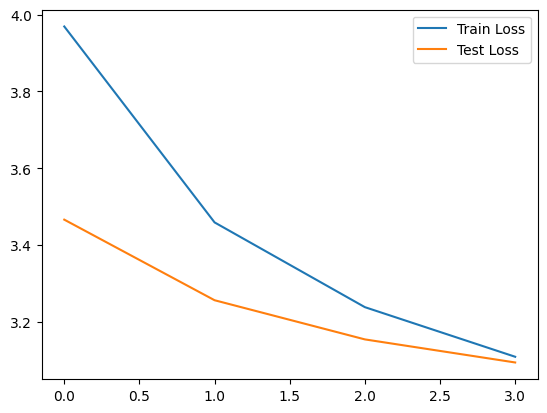

In [55]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()

### Traduzindo

Para finalizar, vamos testar o modelo e ver o resultado da tradução.

Para facilitar a visualização dos resultados, criaremos duas funções que vão receber uma lista de ids de tokens e retornar um string com os tokens. Assim, resultando no texto que a lista de ids de tokens representa. Precisamos de duas funções, pois uma usa o vocabulário em inglês e outra o em alemão.

In [51]:
def to_en_text(ids):
  return ' '.join([vocab_en.get_itos()[id] for id in ids])

def to_de_text(ids):
  return ' '.join([vocab_de.get_itos()[id] for id in ids])

Para a primeira listas de ids de tokens no dataset de teste:

In [52]:
test_dataset[0]

(tensor([   3,   34,    9, 4495,    2]), tensor([ 0,  4, 41,  2,  1]))

Temos os seguintes textos:

In [53]:
to_en_text(test_dataset[0][0]), to_de_text(test_dataset[0][1])

("i 'm a translator .", '<sos> ich bin . <eos>')

No código abaixo, vamos testar a tradução para 10 exemplos do conjunto de teste. Os índices dos exemplos estão na variável `indexes`. Para efetuar a tradução, executaremos o Encoder e em seguida executaremos o Decoder para gerar tokens até ser gerado um `<eos>` ou um total de 50 tokens.

O código abaixo possui comentários para explicar o seu funcionamento de forma detalhada.

In [54]:
# Índices com os exemplos do dataset de teste que serão traduzidos.
indexes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for index in indexes:

  # Não vamos atualizar o modelo, por isso, podemos desabilitar o cálculo dos
  # gradientes.
  with torch.no_grad():
    # O exemplo em inglês, que é a entrada, está no índice 0.
    source = test_dataset[index][0]

    # A saída começa com o token <sos> que é representado pelo índice 0.
    target = torch.tensor([0])

    print('translating:', to_en_text(source))
    print('expected:', to_de_text(test_dataset[index][1]))

    # Os dados são passados para a GPU.
    source = source.to(device)
    target = target.to(device)

    # O Encoder é executado. O hidden e o cell aqui retornados são usados na
    # primeira execução do Decoder.
    hidden, cell = encoder(source)

    # O Decoder é executado 50 vezes ou até ser gerado um token <eos>.
    result = []
    for i in range(50):
      output, hidden, cell = decoder(target, hidden, cell)

      # O índice do token de saída é o índice com maior valor na saída do Decoder.
      target = output.argmax(1)
      result.append(target.item())  # O índice é adicionado a lista de resultado.

      # Se o token for <eos>, que possui índice 1, a tradução é terminada.
      if target.item() == 1:
        break

    print('result:', to_de_text(result))
  print()

translating: tom is exactly like his father .
expected: <sos> tom ist ganz genau so wie sein vater . <eos>
result: tom sieht aus wie sein vater . <eos>

translating: i ca n't do that again .
expected: <sos> ich kann das nicht noch einmal machen . <eos>
result: ich kann das nicht wieder tun . <eos>

translating: the cart was in the shed .
expected: <sos> der stand i m . <eos>
result: die sind in der . <eos>

translating: my grandmother on my father 's side has turned one hundred .
expected: <sos> meine großmutter väterlicherseits ist hundert geworden . <eos>
result: meine mutter hat einen neuen vater . <eos>

translating: which movie did you watch today ?
expected: <sos> welchen film haben sie heute gesehen ? <eos>
result: was hast du heute abend ? <eos>

translating: what 's the asking price ?
expected: <sos> was ist die ? <eos>
result: was ist das von der frage ? <eos>

translating: thanks for pointing that out to me .
expected: <sos> danke , dass ihr mich darauf habt ! <eos>
result: 

Existem acertos, alguns erros menores e outros muito grandes. Muitas melhorias podem ser feitas ainda nesse modelo. Nós treinamos por poucas épocas e também com poucos dados. Além disso, existem melhorias na arquitetura da rede, como a inclusão do mecanismo de atenção que não foi usado na nossa implementação.